# mercari

# 前書き
何が本当に価値があるかを知ることは難しいかもしれません。細かいことは、価格の大きな違いを意味します。例えば、これらのセーターの1つは335ドル、もう1人は9.99ドルです。あなたはどちらがどちらだと思いますか？



オンラインで販売されている製品の数だけを考慮すると、製品の価格設定はさらに困難になります。衣料品は季節的な価格傾向が強く、ブランド名の影響を大きく受け、エレクトロニクスは製品仕様に基づいて価格が変動します。

日本最大級のコミュニティ向けショッピングアプリ「メルカリ」は、この問題を深く知っています。彼らは売り手に価格提案を提供したいのですが、売り手がMercariのマーケットプレイスに何か、または何かのものを置くことができるので、これは厳しいものです。

このコンペで、Mercariは、適切な製品価格を自動的に提案するアルゴリズムを構築することに挑戦しています。製品のカテゴリ名、ブランド名、品目条件などの詳細を含む、ユーザーが入力した製品のテキストの説明が表示されます。

このデータの公的性質のため、この競技は「カーネルズオンリー」競技であることに注意してください。チャレンジの第2段階では、ファイルはカーネルを通じてのみ利用可能となり、新しいデータに対応してアプローチを変更することはできません。詳細については、データタブとカーネルFAQページを参照してください。

## カーネルの目標
このカーネルではEDAから自然言語処理を利用した値段の予測を行います。

# 必要なライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# データのインポート

In [2]:
train = pd.read_csv("all/train.tsv",delimiter='\t' )
test = pd.read_csv("all/test.tsv",delimiter='\t')

# データ探索

In [3]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


まずデータを見てみると、train_id	name	item_condition_id	category_name	brand_name	price	shipping	item_description  
の特徴があることがわかりました。  
priceは今回のターゲット（教師ラベル)になります。  
実際に欠損があるかやデータ型を調べていきましょう。

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [6]:
train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

priceが０のデータがあるので、今回は削除しましょう。

In [7]:
train = train.drop(train[train.price == 0].index)

次にカテゴリーネームとブランドネームの欠損を埋めます

In [9]:
def preprocess(dataset):
    
    print("Filling Missing Values")
    dataset['category_name'].fillna(value='missing', inplace=True)
    dataset['brand_name'].fillna(value='missing', inplace=True)
    dataset['item_description'].fillna(value='missing', inplace=True)

In [10]:
preprocess(train)
preprocess(test)

Filling Missing Values
Filling Missing Values


category_name ,brand_name 　,item_description に欠損があることが確認できました。  
またbrand_nameに関しては半数近くが欠損となっています。
category_nameは3つに別れていることがわかります。  
この1つの特徴を3つに分割しましょう。

In [11]:
catecory_name = train["category_name"].str.split("/",expand=True)
train["category_name1"] = catecory_name[0]
train["category_name2"] = catecory_name[1]
train["category_name3"] = catecory_name[2]

In [12]:
catecory_name = test["category_name"].str.split("/",expand=True)
test["category_name1"] = catecory_name[0]
test["category_name2"] = catecory_name[1]
test["category_name3"] = catecory_name[2]

In [13]:
train = train.drop(["category_name"],axis = 1)

In [14]:
test = test.drop(["category_name"],axis = 1)

In [15]:
train.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,category_name1,category_name2,category_name3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,missing,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,missing,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


これでカテゴリーを分けることができました。  
実際にどのようなカテゴリーがあるか見ていきましょう

In [16]:
set(train["category_name1"])

{'Beauty',
 'Electronics',
 'Handmade',
 'Home',
 'Kids',
 'Men',
 'Other',
 'Sports & Outdoors',
 'Vintage & Collectibles',
 'Women',
 'missing'}

In [17]:
set(train["category_name2"])

{'Accessories',
 'Antique',
 'Apparel',
 'Art',
 'Artwork',
 'Athletic Apparel',
 'Automotive',
 'Bags and Purses',
 'Bath',
 'Bath & Body',
 'Bathing & Skin Care',
 'Bedding',
 'Blazers & Sport Coats',
 'Book',
 'Books',
 'Books and Zines',
 'Boys (4+)',
 'Boys 0-24 Mos',
 'Boys 2T-5T',
 'Cameras & Photography',
 'Candles',
 'Car Audio, Video & GPS',
 'Car Seats & Accessories',
 'Cell Phones & Accessories',
 'Ceramics and Pottery',
 'Children',
 'Cleaning Supplies',
 'Clothing',
 'Coats & Jackets',
 'Collectibles',
 'Computers & Tablets',
 'Crochet',
 'Daily & Travel items',
 'Diapering',
 'Dolls and Miniatures',
 'Dresses',
 'Electronics',
 'Exercise',
 'Fan Shop',
 'Feeding',
 'Footwear',
 'Fragrance',
 'Furniture',
 'Gear',
 'Geekery',
 'Girls (4+)',
 'Girls 0-24 Mos',
 'Girls 2T-5T',
 'Glass',
 'Golf',
 'Hair Care',
 'Health & Baby Care',
 'Holidays',
 'Home Appliances',
 'Home Decor',
 'Home Décor',
 'Housewares',
 'Jeans',
 'Jewelry',
 "Kids' Home Store",
 'Kitchen & Dining',
 '

In [18]:
set(train["category_name3"])

{'100 Years or Older',
 '50 To 75 Years',
 '75 To 100 Years',
 'A-Line',
 'Above Knee, Mini',
 'Accessories',
 'Accessory',
 'Aceo',
 'Action Figure',
 'Action Figures & Statues',
 'Action, Adventure',
 'Activity Centers & Entertainers',
 'Advertisement',
 'Afghan',
 'Air Conditioners',
 'Air Fresheners',
 'Air Purifiers',
 'All Other Sports',
 'Amplifiers & Effects',
 'Animal',
 'Animals',
 'Animation',
 'Apron',
 'Area Rugs & Pads',
 'Art',
 'Art Doll',
 'Artist Bears',
 'Arts & Crafts',
 'Arts & Photography',
 'Asymmetrical',
 'Asymmetrical Hem',
 'Athletic',
 'Athletic Apparel',
 'Athletic Training',
 'Automotive Enthusiast Merchandise',
 'Baby',
 'Baby & Child Care',
 'Baby & Toddler Toys',
 'Baby Gyms & Playmats',
 'Baby Seats',
 'Backpack',
 'Backpack Style',
 'Backpacks & Carriers',
 'Backpacks, Bags & Briefcases',
 'Badminton',
 'Baggy, Loose',
 'Bags & Cases',
 'Bags and Purses',
 'Baguette',
 'Bakeware',
 'Band & Orchestra',
 'Baseball & Softball',
 'Basic Supplies',
 'Baske

カテゴリーネームは3に行くにつれて細かく分類されていることがわかりました。  
カテゴリー別の値段を見てみましょう

Text(0.5,1,'category_price_mean')

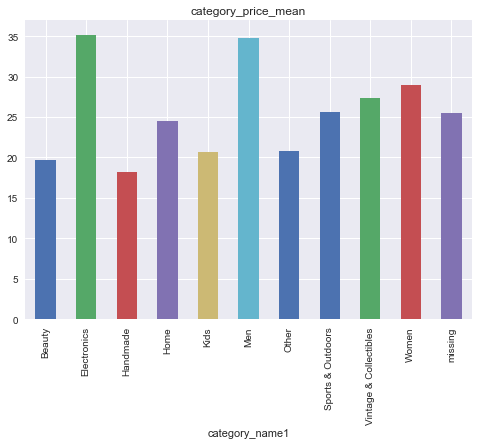

In [19]:
train.groupby("category_name1")["price"].mean().plot.bar()
plt.title("category_price_mean")

男物と家電は値段が高いことがわかりました。  
この平均額は新しい特徴になりそうなので、追加しましょう。

In [20]:
price_mean = train.groupby("category_name1")["price"].mean().reset_index()
price_mean2 = train.groupby("category_name2")["price"].mean().reset_index()
price_mean3 = train.groupby("category_name3")["price"].mean().reset_index()

In [21]:
price_mean.head()

,category_name1,price
0,Beauty,19.681290
1,Electronics,35.190558
2,Handmade,18.160694
3,Home,24.551068
4,Kids,20.658439


In [22]:
price_mean.columns = ['category_name1', 'mean_price1']
price_mean2.columns = ['category_name2', 'mean_price2']
price_mean3.columns = ['category_name3', 'mean_price3']

In [23]:
train = pd.merge(train,price_mean,on="category_name1",how = "left")
train = pd.merge(train,price_mean2,on="category_name2",how = "left")
train = pd.merge(train,price_mean3,on="category_name3",how = "left")

test = pd.merge(test,price_mean,on="category_name1",how = "left")
test = pd.merge(test,price_mean2,on="category_name2",how = "left")
test = pd.merge(test,price_mean3,on="category_name3",how = "left")

In [24]:
train.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,category_name1,category_name2,category_name3,mean_price1,mean_price2,mean_price3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,missing,10.0,1,No description yet,Men,Tops,T-shirts,34.734940,19.014216,18.368301
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,35.190558,87.970533,42.913900
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,28.902679,18.249287,15.671262
3,3,Leather Horse Statues,1,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,24.551068,21.581724,22.203802
4,4,24K GOLD plated rose,1,missing,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,28.902679,27.516272,25.597873


次にブランドという項目があることがわかります。  
ブランドによっては最高値や最安値が安定します。  
ですのでブランドとpriceの最高値と最安値を新しい特徴として追加しましょう。

In [25]:
brand_mean = train.groupby("brand_name")["price"].mean().reset_index()
brand_max = train.groupby("brand_name")["price"].max().reset_index()
brand_min = train.groupby("brand_name")["price"].min().reset_index()

In [26]:
brand_mean = brand_mean.rename(columns={"price":"brand_price_mean"})
brand_max = brand_max.rename(columns={"price":"brand_price_max"})
brand_min = brand_min.rename(columns={"price":"brand_price_min"})

In [27]:
brand_mean

,brand_name,brand_price_mean
0,!iT Jeans,16.000000
1,% Pure,16.344262
2,10.Deep,17.333333
3,191 Unlimited,36.000000
4,1byone,51.000000
5,21men,12.166667
6,24/7 Comfort Apparel,47.000000
7,2K Games,9.000000
8,2XU,32.000000
9,3.1 Phillip Lim,141.619048


In [28]:
train = pd.merge(train,brand_mean,on="brand_name",how = "left")
train = pd.merge(train,brand_max,on="brand_name",how = "left")
train = pd.merge(train,brand_min,on="brand_name",how = "left")
test = pd.merge(test,brand_mean,on="brand_name",how = "left")
test = pd.merge(test,brand_max,on="brand_name",how = "left")
test = pd.merge(test,brand_min,on="brand_name",how = "left")

また今回は自然言語処理を行いたいので、item_descriptionに注目してみましょう

In [29]:
train["item_description"].head(10)

0                                   No description yet
1    This keyboard is in great condition and works ...
2    Adorable top with a hint of lace and a key hol...
3    New with tags. Leather horses. Retail for [rm]...
4            Complete with certificate of authenticity
5    Banana republic bottoms, Candies skirt with ma...
6    Size small but straps slightly shortened to fi...
7    You get three pairs of Sophie cheer shorts siz...
8     Girls Size small Plus green. Three shorts total.
9    I realized his pants are on backwards after th...
Name: item_description, dtype: object

1つの仮説として説明が長い商品は高く値段がつきやすい気がします。  
説明文(item_description)の文字数を新しい特徴に加えましょう。

In [30]:
train["word_count"] = train["item_description"].str.len()

In [31]:
test["word_count"] = test["item_description"].str.len()

In [32]:
train.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,category_name1,category_name2,category_name3,mean_price1,mean_price2,mean_price3,brand_price_mean,brand_price_max,brand_price_min,word_count
0,0,MLB Cincinnati Reds T Shirt Size XL,3,missing,10.0,1,No description yet,Men,Tops,T-shirts,34.734940,19.014216,18.368301,21.145017,2000.0,3.0,18
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,35.190558,87.970533,42.913900,45.021277,150.0,12.0,188
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,28.902679,18.249287,15.671262,15.047109,197.0,3.0,124
3,3,Leather Horse Statues,1,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,24.551068,21.581724,22.203802,21.145017,2000.0,3.0,173
4,4,24K GOLD plated rose,1,missing,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,28.902679,27.516272,25.597873,21.145017,2000.0,3.0,41


次にコンディションが良い物と悪い物でどういった言葉が使われているか数えてみましょう

In [33]:
data_word = train[["item_condition_id","item_description"]].append(test[["item_condition_id","item_description"]])

In [34]:
data_word["item_description"] = data_word["item_description"].str.lower()

In [35]:
data_word.head()

,item_condition_id,item_description
0,3,no description yet
1,3,this keyboard is in great condition and works ...
2,1,adorable top with a hint of lace and a key hol...
3,1,new with tags. leather horses. retail for [rm]...
4,1,complete with certificate of authenticity


In [36]:
good_word = data_word[data_word["item_condition_id"]==3]["item_description"].str.replace("."," .")
bad_word = data_word[data_word["item_condition_id"]==1]["item_description"].str.replace("."," .")

In [37]:
# good_word = " ".join(good_word.astype("str"))
# bad_word = " ".join(bad_word.astype("str"))

# 単語の出現頻度計算

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

In [39]:
vectorizer = CountVectorizer(max_features = 10,stop_words="english")
good_word_vec = vectorizer.fit_transform(good_word.astype("str"))

In [40]:
vectorizer.get_feature_names()

['black',
 'condition',
 'free',
 'good',
 'great',
 'shipping',
 'size',
 'small',
 'used',
 'worn']

コンディションの良い文章にはこの単語が多く使われていることがわかりました。  
コンディションが悪い方もみていきましょう。

In [41]:
vectorizer1 = CountVectorizer(max_features = 10,stop_words="english")
bad_word_vec = vectorizer1.fit_transform(bad_word.astype("str"))

In [42]:
vectorizer1.get_feature_names()

['black',
 'brand',
 'color',
 'free',
 'new',
 'price',
 'rm',
 'shipping',
 'size',
 'tags']

In [43]:
good = vectorizer.get_feature_names()
bad = vectorizer1.get_feature_names()

In [44]:
word = set(good ) ^ set(bad)

In [45]:
word

{'brand',
 'color',
 'condition',
 'good',
 'great',
 'new',
 'price',
 'rm',
 'small',
 'tags',
 'used',
 'worn'}

状態が良いコメントに使われている単語と状態が悪いコメントに使われている単語を抽出することができました。  
この単語が使われている数をカウントし新しい特徴として追加しましょう。

In [46]:
vectorizer = CountVectorizer(max_features = 10,stop_words="english",vocabulary=word)
train_vec = vectorizer.fit_transform(train["item_description"].astype("str"))
test_vec = vectorizer.fit_transform(test["item_description"].astype("str"))

In [47]:
train.shape

(1481661, 17)

In [48]:
train_vec = pd.DataFrame(train_vec.toarray())
test_vec = pd.DataFrame(test_vec.toarray())

In [49]:
word_col = vectorizer.get_feature_names()

In [50]:
word_col[6] = "price_word"

In [51]:
word_col

['brand',
 'color',
 'condition',
 'good',
 'great',
 'new',
 'price_word',
 'rm',
 'small',
 'tags',
 'used',
 'worn']

In [52]:
train_vec.columns = word_col
test_vec.columns = word_col

In [53]:
train = pd.concat([train,train_vec],axis = 1)

In [54]:
test = pd.concat([test,test_vec],axis = 1)

In [55]:
train.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,category_name1,category_name2,category_name3,...,condition,good,great,new,price_word,rm,small,tags,used,worn
0,0,MLB Cincinnati Reds T Shirt Size XL,3,missing,10.0,1,No description yet,Men,Tops,T-shirts,...,0,0,0,0,0,0,0,0,0,0
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,...,1,0,1,0,0,0,0,0,0,0
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,...,0,0,0,0,0,0,0,0,0,0
3,3,Leather Horse Statues,1,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,...,0,0,0,1,0,1,0,1,0,0
4,4,24K GOLD plated rose,1,missing,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,...,0,0,0,0,0,0,0,0,0,0


しっかり言語をベクトルにすることができたので、item_descriptionを削除しましょう

In [56]:
train = train.drop("item_description",axis = 1)
test = test.drop("item_description",axis = 1)

一度相関をみてみましょう。

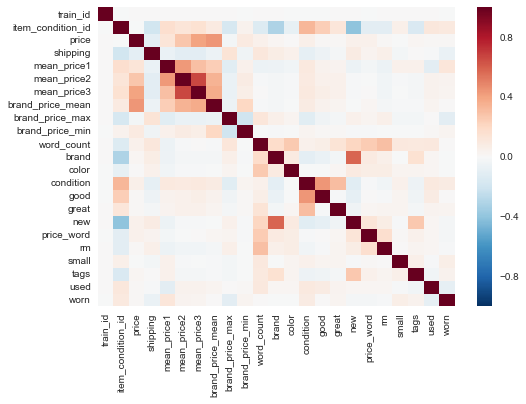

In [57]:
sns.heatmap(train.corr())

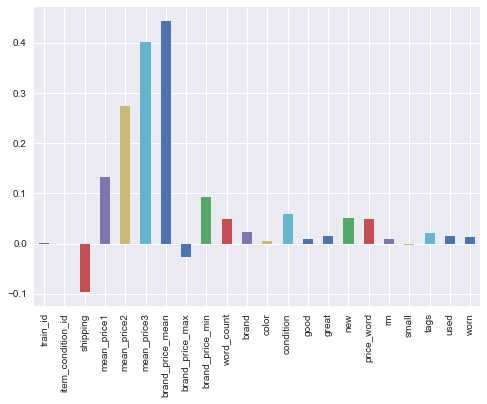

In [58]:
train.corr().price.drop("price").plot.bar()

それなりに相関のある特徴を作ることができていることが分かりました

次にobjectをkategoryに変換を行っていきましょう。

In [59]:
def change(x):
    for i in x.columns:
        if x[i].dtypes == "object":
            x[i] = x[i].astype("category")

In [60]:
change(train)

In [61]:
change(test)

In [62]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

X = train.drop(["price","train_id"],axis = 1)
y = train["price"]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.1, random_state = 144) 


def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5
def relu(x):
    return np.maximum(0, x)


In [63]:
import lightgbm as lgb


In [64]:
d_trainL2 = lgb.Dataset(train_X, label=train_y)
d_validL2 = lgb.Dataset(test_X, label=test_y)
watchlistL2 = [d_trainL2, d_validL2]
paramsL2 = {
        'learning_rate': 0.1,
        'application': 'regression',
        'max_depth': 7,
        'num_leaves': 50,
        'verbosity': -1,
        'metric': 'RMSE',
        'data_random_seed': 2,
        'bagging_fraction': 1,
        'nthread': 4,
        "n_estimators":200,
        "min_child_samples":20
    }
modelL2 = lgb.train(paramsL2, train_set=d_trainL2, num_boost_round=500, valid_sets=watchlistL2, \
early_stopping_rounds=300, verbose_eval=50) 
predsL2 = modelL2.predict(test_X)
predsL2 = relu(predsL2)
rmsleL2 = rmsle(predsL2, np.array(test_y))
print ("LightGBM2 RMSLE = " + str(1-rmsleL2))

/Users/ishikawaryuuichi/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/ishikawaryuuichi/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[50]	training's rmse: 29.423	valid_1's rmse: 29.5156
[100]	training's rmse: 28.8843	valid_1's rmse: 29.3317
[150]	training's rmse: 28.585	valid_1's rmse: 29.2316
[200]	training's rmse: 28.3652	valid_1's rmse: 29.166
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 28.3652	valid_1's rmse: 29.166
LightGBM2 RMSLE = 0.4262450156639058


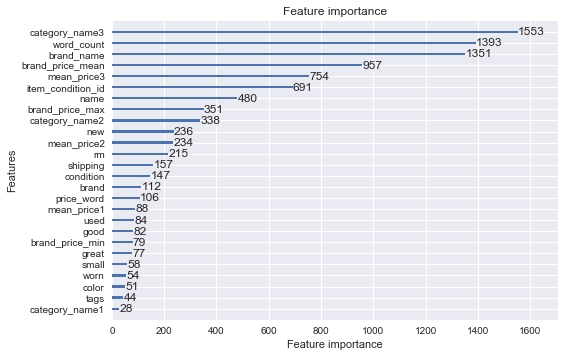

In [65]:
lgb.plot_importance(modelL2)

In [66]:
train.head()

,train_id,name,item_condition_id,brand_name,price,shipping,category_name1,category_name2,category_name3,mean_price1,...,condition,good,great,new,price_word,rm,small,tags,used,worn
0,0,MLB Cincinnati Reds T Shirt Size XL,3,missing,10.0,1,Men,Tops,T-shirts,34.734940,...,0,0,0,0,0,0,0,0,0,0
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,Electronics,Computers & Tablets,Components & Parts,35.190558,...,1,0,1,0,0,0,0,0,0,0
2,2,AVA-VIV Blouse,1,Target,10.0,1,Women,Tops & Blouses,Blouse,28.902679,...,0,0,0,0,0,0,0,0,0,0
3,3,Leather Horse Statues,1,missing,35.0,1,Home,Home Décor,Home Décor Accents,24.551068,...,0,0,0,1,0,1,0,1,0,0
4,4,24K GOLD plated rose,1,missing,44.0,0,Women,Jewelry,Necklaces,28.902679,...,0,0,0,0,0,0,0,0,0,0


In [67]:
train.dtypes

train_id                int64
name                 category
item_condition_id       int64
brand_name           category
price                 float64
shipping                int64
category_name1       category
category_name2       category
category_name3       category
mean_price1           float64
mean_price2           float64
mean_price3           float64
brand_price_mean      float64
brand_price_max       float64
brand_price_min       float64
word_count              int64
brand                   int64
color                   int64
condition               int64
good                    int64
great                   int64
new                     int64
price_word              int64
rm                      int64
small                   int64
tags                    int64
used                    int64
worn                    int64
dtype: object

# NNで学習

In [68]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def les(data):
    
    for col in data.columns:
        if data[col].dtype == "object":
            if len(list(data[col].unique())) <= 2:
                le.fit(data[col])
            
                data[col] = le.transform(data[col])
                
    data = pd.get_dummies(data)
    return data

In [69]:
train = train.drop(["name","category_name3","brand_name"],axis = 1)
test = test.drop(["name","category_name3","brand_name"],axis = 1)

In [70]:
train = les(train)

In [71]:
test = les(test)

In [72]:
train.shape

(1481661, 147)

In [73]:
test.shape

(693359, 146)

# 欠損の処理

In [74]:
train.isnull().sum()

train_id                                      0
item_condition_id                             0
price                                         0
shipping                                      0
mean_price1                                   0
mean_price2                                6314
mean_price3                                6314
brand_price_mean                              0
brand_price_max                               0
brand_price_min                               0
word_count                                    0
brand                                         0
color                                         0
condition                                     0
good                                          0
great                                         0
new                                           0
price_word                                    0
rm                                            0
small                                         0
tags                                    

In [75]:
train["mean_price1"] = train["mean_price1"].fillna(train["mean_price1"].mean())
train["mean_price2"] = train["mean_price2"].fillna(train["mean_price2"].mean())
train["mean_price3"] = train["mean_price3"].fillna(train["mean_price3"].mean())

train["brand_price_mean"] = train["brand_price_mean"].fillna(train["brand_price_mean"].mean())
train["brand_price_max"] = train["brand_price_max"].fillna(train["brand_price_max"].mean())
train["brand_price_min"] = train["brand_price_min"].fillna(train["brand_price_min"].mean())

train["word_count"] = train["word_count"].fillna(0)

In [76]:
test["mean_price1"] = test["mean_price1"].fillna(test["mean_price1"].mean())
test["mean_price2"] = test["mean_price2"].fillna(test["mean_price2"].mean())
test["mean_price3"] = test["mean_price3"].fillna(test["mean_price3"].mean())

test["brand_price_mean"] = test["brand_price_mean"].fillna(test["brand_price_mean"].mean())
test["brand_price_max"] = test["brand_price_max"].fillna(test["brand_price_max"].mean())
test["brand_price_min"] = test["brand_price_min"].fillna(test["brand_price_min"].mean())

test["word_count"] = test["word_count"].fillna(0)

In [77]:
target = train["price"]

In [78]:
def drop_col(x,d_col):
    d_list = []
    for i in d_col:
        if i in x.columns:
            d_list.append(i)
    return d_list

In [79]:
X = train.drop("price",axis = 1)
y = target

In [80]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 標準化
sc = StandardScaler()
X = sc.fit_transform(X)

In [81]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.1, random_state = 144) 

In [82]:
def rmsle(y, y_pred):
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [86]:
from keras.models import Model
from keras.layers import Input, Dense
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Input = Input(shape = (146,))
x = Dense(256,activation="relu")(Input)
x = keras.layers.BatchNormalization()(x)
y = Dense(1,activation="relu")(x)

model = Model(inputs=Input,outputs=y)

In [87]:
c = keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="mse",optimizer="sgd")

In [88]:
model.fit(train_X[:100000],train_y[:100000],batch_size=1000,epochs= 5)

Epoch 1/5
100000/100000 [==============================] - 7s 66us/step - loss: 1181.8991

In [89]:
pred = model.predict(test_X)

In [90]:
pred = rmsle(pred, np.array(test_y))

In [91]:
print ("LightGBM2 RMSLE = " + str(pred))

LightGBM2 RMSLE = 0.7720323118764142


# スタッキング

In [92]:
from stacked_generalization.lib.stacking import StackedRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn import datasets, metrics


# Stage 1 model
bclf = LinearRegression()

# Stage 0 models
clfs = [RandomForestRegressor(n_estimators=40, random_state=1),
        GradientBoostingRegressor(n_estimators=25, random_state=1)]

# same interface as scikit-learn
sl = StackedRegressor(bclf, clfs)
sl.fit(y_train=np.array(train_y[:1000]), xs_train=np.array(train_X[:1000]))
pre2 = sl.predict(test_X)
pre2 = relu(pre2)
pre2 = rmsle(pre2, np.array(test_y))
print ("LightGBM2 RMSLE = " + str(pre2))

/Users/ishikawaryuuichi/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ishikawaryuuichi/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


LightGBM2 RMSLE = 0.6641402877555783
